## Breast Cancer Classification


In [ ]:
import tensorflow as tf
# importing required modules
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Add, Subtract, Activation, BatchNormalization ,Dropout, Flatten, Dense, Conv2D, AveragePooling2D, MaxPooling2D, Input, Subtract
import warnings
from tensorflow.keras.callbacks import ModelCheckpoint
import cv2
import tensorflow as tf
from skimage import transform
import numpy as np
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model
import numpy as np
import keras.utils
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LeakyReLU

from tensorflow.keras.models import model_from_json
IMAGE_SIZE = (224, 340)
CROP_SIZE = (224, 224)
BATCH_SIZE = 128

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, BatchNormalization
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense, Flatten, Activation


def vgginnet_builder():
    base_model = VGG16(include_top=False, input_shape=(250, 250, 3))

    layer_name = 'block4_pool'
    feature_ex_model = Model(inputs=base_model.input,
                             outputs=base_model.get_layer(layer_name).output,
                             name='vgg16_features')
    feature_ex_model.trainable = False

    p1_layer = Lambda(vgg_preprocess, name='VGG_Preprocess')
    image_input = Input((250, 250, 3), name='Image_Input')
    p1_tensor = p1_layer(image_input)

    out =feature_ex_model(p1_tensor)
    feature_ex_model = Model(inputs=image_input, outputs=out)

    def naive_inception_module(layer_in, f1, f2, f3):
        # 1x1 conv
        conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
        # 3x3 conv
        conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
        # 5x5 conv
        conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
        # 3x3 max pooling
        pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
        # concatenate filters, assumes filters/channels last
        layer_out = Concatenate()([conv1, conv3, conv5, pool])
        return layer_out

    out = naive_inception_module(feature_ex_model.output, 64, 128, 32)
    num_classes = 2

    bn1 = BatchNormalization(name='BN')(out)
    f = Flatten()(bn1)
    dropout = Dropout(0.4, name='Dropout')(f)
    desne = Dense(num_classes, activation='softmax', name='Predictions')(dropout)

    model = Model(inputs=feature_ex_model.input, outputs=desne)
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=['accuracy'])
    return model

In [ ]:
def model_probas(test_dataset, model):
    """Returns the predicted probabilities and the true labels
    for a given (inference) dataset on a given model."""
    y_test, y_probas = [], []

    for image_batch, label_batch in test_dataset:
        y_test.append(label_batch)
        y_probas.append(model.predict(image_batch))

    y_test, y_probas = (
        tf.concat(y_test, axis=0),
        tf.concat(y_probas, axis=0))

    return {
        'y_test': y_test,
        'y_probas': y_probas
    }

In [ ]:
!cp -r /content/drive/MyDrive/Breast_Cancer/Dataset-Resized/test /content/drive/MyDrive/Breast_Cancer/Dataset-SOTA-Experiment

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
path_src = '/content/drive/MyDrive/Breast_Cancer/Dataset-SOTA-Experiment/train+val'
path_out = '/content/drive/MyDrive/Breast_Cancer/Dataset-SOTA-Experiment/'
splitfolders.ratio(path_src, output=path_out, seed=1337, ratio=(.75, .25, .0), group_prefix=None, move=False) # default values


Copying files: 8484 files [01:11, 118.50 files/s]


In [ ]:

# augmenting the ibput imges
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)
# initializing paths of input images
path_images = '/content/drive/MyDrive/Breast_Cancer/Dataset-SOTA-Experiment/'

batch_size = 64
image_shape = (250,250,3)

# train on images
train_image_gen = image_gen.flow_from_directory(path_images + '/train',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='categorical')

valid_image_gen = image_gen.flow_from_directory(path_images + '/val',
                                                target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='categorical')




Found 6362 images belonging to 2 classes.
Found 2120 images belonging to 2 classes.


In [ ]:
model = vgginnet_builder()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 VGG_Preprocess (Lambda)        (None, 250, 250, 3)  0           ['Image_Input[0][0]']            
                                                                                                  
 vgg16_features (Functional)    (None, 15, 15, 512)  7635264     ['VGG_Preprocess[0][0]']         
                                                                                                  
 conv2d_3 (Conv2D)              (None, 15, 15, 64)   32832       ['vgg16_features[0][0]']   

In [ ]:
# warnings.filterwarnings('ignore')

#es = EarlyStopping(monitor='val_acc', mode='max', verbose=1 , patience = 10)
cb = []
checkpoint_dir = '/content/drive/MyDrive/Breast_Cancer/Checkpoints/'

# checkpoint = ModelCheckpoint("california.h5", save_best_only=True)
# ckp_saver = ModelCheckpoint(checkpoint_dir + "/model.{epoch:02d}-{loss:.2f}.h5", monitor='val_loss', verbose = 0,
#                                     save_best_only=True,
#                                     save_weights_only=True, mode='auto', period=1)
# cb.append(ckp_saver)
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

results = model.fit_generator(train_image_gen,epochs=30,
                              steps_per_epoch=train_image_gen.samples//batch_size,
                              validation_data=valid_image_gen,
                             validation_steps=valid_image_gen.samples//batch_size,
                              callbacks=[es],
                              verbose = 1)
model.save('/content/drive/MyDrive/Breast_Cancer/Checkpoints/VGGIN-Net.h5')

<ipython-input-55-ea65e4b31048>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(train_image_gen,epochs=30,


Epoch 1/30
99/99 [==============================] - 129s 1s/step - loss: 0.2333 - accuracy: 0.9436 - val_loss: 0.2423 - val_accuracy: 0.9422
Epoch 2/30
99/99 [==============================] - 126s 1s/step - loss: 0.2314 - accuracy: 0.9428 - val_loss: 0.3911 - val_accuracy: 0.9152
Epoch 3/30
99/99 [==============================] - 126s 1s/step - loss: 0.2344 - accuracy: 0.9446 - val_loss: 0.2428 - val_accuracy: 0.9441
Epoch 4/30
99/99 [==============================] - 127s 1s/step - loss: 0.2182 - accuracy: 0.9476 - val_loss: 0.2931 - val_accuracy: 0.9332
Epoch 5/30
99/99 [==============================] - 126s 1s/step - loss: 0.1981 - accuracy: 0.9495 - val_loss: 0.2471 - val_accuracy: 0.9503
Epoch 6/30
99/99 [==============================] - 127s 1s/step - loss: 0.1954 - accuracy: 0.9533 - val_loss: 0.2689 - val_accuracy: 0.9394
Epoch 7/30
99/99 [==============================] - 126s 1s/step - loss: 0.1985 - accuracy: 0.9530 - val_loss: 0.3270 - val_accuracy: 0.9418
Epoch 8/30
99

In [ ]:
path_images = '/content/drive/MyDrive/Breast_Cancer/Dataset-SOTA-Experiment/'

test_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)
test_generator = test_datagen.flow_from_directory(path_images + '/test/',
                                                        target_size=image_shape[:2],
                                                        batch_size=batch_size,
                                                        shuffle = False,
                                                        class_mode='categorical')

Found 2126 images belonging to 2 classes.


In [ ]:
loaded_model = load_model('/content/drive/MyDrive/Breast_Cancer/Checkpoints/VGGIN-Net.h5')
loaded_model.layers[0].input_shape #(None, 160, 160, 3)
loaded_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 VGG_Preprocess (Lambda)        (None, 250, 250, 3)  0           ['Image_Input[0][0]']            
                                                                                                  
 vgg16_features (Functional)    (None, 15, 15, 512)  7635264     ['VGG_Preprocess[0][0]']         
                                                                                                  
 conv2d_3 (Conv2D)              (None, 15, 15, 64)   32832       ['vgg16_features[0][0]']   

In [ ]:
import numpy as np
# test_generator.reset()
Y_pred = loaded_model.predict_generator(test_generator, len(test_generator.classes) // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['0: benign',' 1: malignant']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

<ipython-input-59-3d3bf3f623ec>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = loaded_model.predict_generator(test_generator, len(test_generator.classes) // batch_size+1)


Confusion Matrix
[[1013   50]
 [  57 1006]]
Classification Report
               precision    recall  f1-score   support

    0: benign       0.95      0.95      0.95      1063
 1: malignant       0.95      0.95      0.95      1063

     accuracy                           0.95      2126
    macro avg       0.95      0.95      0.95      2126
 weighted avg       0.95      0.95      0.95      2126



In [61]:
print(classification_report(test_generator.classes, y_pred, target_names=target_names,digits=4))

               precision    recall  f1-score   support

    0: benign     0.9467    0.9530    0.9498      1063
 1: malignant     0.9527    0.9464    0.9495      1063

     accuracy                         0.9497      2126
    macro avg     0.9497    0.9497    0.9497      2126
 weighted avg     0.9497    0.9497    0.9497      2126



### Install dependencies

# Compute metrics

In [ ]:
#!pip install -q datasets transformers
#!pip install accelerate
#!pip install wandb

#load libraries
import matplotlib.pyplot as plt
import numpy as np
# Import the image processor compatible with the given model architecture
import torch
# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

<Axes: xlabel='Predicted Labels', ylabel='Actual Labels'>

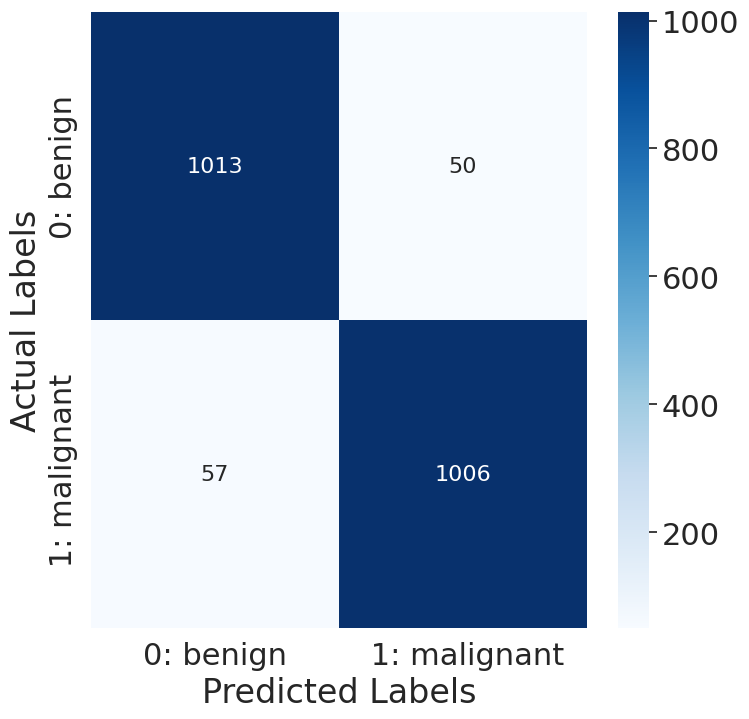

In [62]:
# compute all scores macro and weighted
def evaluation_summary(desc, predictions, true_labels):
    accuracy = accuracy_score(predictions, true_labels)
    precision = precision_score(predictions, true_labels, average='macro')
    recall = recall_score(predictions, true_labels, average='macro')
    f1 = fbeta_score(predictions, true_labels, beta=1, average='macro')
    weighted_precision = precision_score(predictions, true_labels, average='weighted')
    weighted_recall = recall_score(predictions, true_labels, average='weighted')
    weighted_f1 = fbeta_score(predictions, true_labels, beta=1, average='weighted')
    results = {
            "classifier": [desc],
            "accuracy": [round(accuracy,4)],
            "macro_precision": [round(precision,4)],
            "macro_recall": [round(recall,4)],
            "macro_f1": [round(f1,4)],
            "weighted_precision": [round(weighted_precision,4)],
            "weighted_recall": [round(weighted_recall,4)],
            "weighted_f1": [round(weighted_f1,4)]
            }
    return pd.DataFrame.from_dict(results)

# test_pred_labels=predictions.argmax(axis=1)

data = confusion_matrix(test_generator.classes,y_pred,labels=[0,1])
df_cm = pd.DataFrame(data, columns=['0: benign',' 1: malignant'], index = ['0: benign',' 1: malignant'])
df_cm.index.name = 'Actual Labels'
df_cm.columns.name = 'Predicted Labels'
plt.figure(figsize = (8,8))
sn.set(font_scale=2)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')# font size


In [63]:
beit_test_result=evaluation_summary("VGGIN-NET-BreastCancer-Classification-Test data", y_pred , test_generator.classes)

summary_eval = pd.concat([beit_test_result], axis=0)
summary_eval = summary_eval.reset_index(drop=True)
color = (summary_eval.weighted_f1 > 0).map({True: 'background-color: green', False: ''})
summary_eval.style.apply(lambda s: color)

,classifier,accuracy,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1
0,VGGIN-NET-BreastCancer-Classification-Test data,0.949700,0.949700,0.949700,0.949700,0.949700,0.949700,0.949700
